# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [76]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/sambarati/Documents/GitHub/mlfs-book
HopsworksSettings initialized!


In [77]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [96]:
# Reload the util module to pick up any changes
import importlib
importlib.reload(util)

<module 'mlfs.airquality.util' from '/Users/sambarati/Documents/GitHub/mlfs-book/mlfs/airquality/util.py'>

In [78]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 11, 16, 36, 11, 805634)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [79]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-11 16:36:11,814 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-11 16:36:11,815 INFO: Initializing external client
2025-11-11 16:36:11,815 INFO: Base URL: https://c.app.hopsworks.ai:443
Connection closed.
2025-11-11 16:36:11,815 INFO: Initializing external client
2025-11-11 16:36:11,815 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-11 16:36:12,464 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'

2025-11-11 16:36:12,464 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'p

2025-11-11 16:36:13,591 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1267871

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1267871


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

### Model Version Information:
- **Version 1**: Baseline (4 weather features only)
- **Version 2**: Enhanced (7 features: weather + 3 lagged PM2.5 values)

We'll load the best performing model from the training pipeline.

In [80]:
mr = project.get_model_registry()

# Get the latest/best model - change version based on which model won in Notebook 3
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3,  # Use version 2 (enhanced model with lagged features)
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

print(f"✅ Loaded model version {retrieved_model.version}")

2025-11-11 16:36:19,744 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/527756 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98246 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19782 elapsed<00:00 remaining<?

✅ Loaded model version 3ct (1 dirs, 3 files)... DONE


In [81]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='6.10005E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [82]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-12 00:00:00+00:00,15.15,0.0,11.620809,163.810730,Paris
1,2025-11-13 00:00:00+00:00,18.75,0.0,9.028754,184.573837,Paris
2,2025-11-15 00:00:00+00:00,12.60,0.0,8.891343,31.759439,Paris
3,2025-11-14 00:00:00+00:00,15.95,0.0,4.582052,135.000107,Paris
4,2025-11-16 00:00:00+00:00,5.90,0.0,10.703569,47.726372,Paris


In [83]:
# Get air quality feature group (version 2 with lagged features)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)

## <span style="color:#ff5f27;">🔄 Calculate Lagged Features for Prediction</span>

For the enhanced model (v2), we need the last 3 days of PM2.5 values as features.

In [84]:
# Fetch the last 3 days of PM2.5 data to calculate lagged features
three_days_ago = today - datetime.timedelta(days=3)
historical_aq_df = air_quality_fg.filter(air_quality_fg.date >= three_days_ago).read()

# Sort by date to ensure proper ordering
historical_aq_df = historical_aq_df.sort_values(by='date')

# Get the last 3 PM2.5 values for lagged features
if len(historical_aq_df) >= 3:
    pm25_values = historical_aq_df['pm25'].tail(3).values
    
    # Add lagged features to batch_data (same value for all forecast days)
    # Explicitly convert to float to avoid dtype issues
    batch_data['pm_25_1_day_lag'] = float(pm25_values[-1])  # Yesterday's PM2.5
    batch_data['pm_25_2_day_lag'] = float(pm25_values[-2])  # 2 days ago
    batch_data['pm_25_3_day_lag'] = float(pm25_values[-3])  # 3 days ago
    
    print(f"✅ Lagged features added:")
    print(f"   1-day lag: {pm25_values[-1]:.2f}")
    print(f"   2-day lag: {pm25_values[-2]:.2f}")
    print(f"   3-day lag: {pm25_values[-3]:.2f}")
else:
    print(f"⚠️ Warning: Not enough historical data for lagged features")
    print(f"   Found {len(historical_aq_df)} days, need 3")
    # Set to NaN instead of None for numeric columns
    batch_data['pm_25_1_day_lag'] = float('nan')
    batch_data['pm_25_2_day_lag'] = float('nan')
    batch_data['pm_25_3_day_lag'] = float('nan')

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 
⚠️ Warning: Not enough historical data for lagged features
   Found 1 days, need 3
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 
⚠️ Warning: Not enough historical data for lagged features
   Found 1 days, need 3


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm_25_1_day_lag,pm_25_2_day_lag,pm_25_3_day_lag
0,2025-11-12 00:00:00+00:00,15.15,0.0,11.620809,163.810730,Paris,NaN,NaN,NaN
1,2025-11-13 00:00:00+00:00,18.75,0.0,9.028754,184.573837,Paris,NaN,NaN,NaN
2,2025-11-15 00:00:00+00:00,12.60,0.0,8.891343,31.759439,Paris,NaN,NaN,NaN
3,2025-11-14 00:00:00+00:00,15.95,0.0,4.582052,135.000107,Paris,NaN,NaN,NaN
4,2025-11-16 00:00:00+00:00,5.90,0.0,10.703569,47.726372,Paris,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

Using the enhanced model with weather features + lagged PM2.5 values.

In [85]:
# Define feature columns based on model version
# IMPORTANT: Order must match training order!
# Model was trained with lagged features FIRST, then weather features

feature_columns = []

# Add lagged features first if they exist in batch_data
if 'pm_25_1_day_lag' in batch_data.columns:
    feature_columns.extend(['pm_25_1_day_lag', 'pm_25_2_day_lag', 'pm_25_3_day_lag'])
    print(f"✅ Added lagged features")

# Then add weather features
feature_columns.extend([
    'temperature_2m_mean', 
    'precipitation_sum', 
    'wind_speed_10m_max', 
    'wind_direction_10m_dominant'
])

print(f"✅ Using {len(feature_columns)} features: {feature_columns}")

# Make predictions
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[feature_columns])

print(f"\nPredictions generated for {len(batch_data)} days")
batch_data

✅ Added lagged features
✅ Using 7 features: ['pm_25_1_day_lag', 'pm_25_2_day_lag', 'pm_25_3_day_lag', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']

Predictions generated for 5 days


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm_25_1_day_lag,pm_25_2_day_lag,pm_25_3_day_lag,predicted_pm25
0,2025-11-12 00:00:00+00:00,15.15,0.0,11.620809,163.810730,Paris,NaN,NaN,NaN,138.781586
1,2025-11-13 00:00:00+00:00,18.75,0.0,9.028754,184.573837,Paris,NaN,NaN,NaN,139.050171
2,2025-11-15 00:00:00+00:00,12.60,0.0,8.891343,31.759439,Paris,NaN,NaN,NaN,137.640503
3,2025-11-14 00:00:00+00:00,15.95,0.0,4.582052,135.000107,Paris,NaN,NaN,NaN,134.829178
4,2025-11-16 00:00:00+00:00,5.90,0.0,10.703569,47.726372,Paris,NaN,NaN,NaN,153.907394


In [86]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   pm_25_1_day_lag              0 non-null      float64                
 7   pm_25_2_day_lag              0 non-null      float64                
 8   pm_25_3_day_lag              0 non-null      float64                
 9   predicted_pm25               5 non-null      float32                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [87]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm_25_1_day_lag,pm_25_2_day_lag,pm_25_3_day_lag,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-12 00:00:00+00:00,15.15,0.0,11.620809,163.810730,Paris,NaN,NaN,NaN,138.781586,Boulevard Peripherique Est,France,1
1,2025-11-13 00:00:00+00:00,18.75,0.0,9.028754,184.573837,Paris,NaN,NaN,NaN,139.050171,Boulevard Peripherique Est,France,2
3,2025-11-14 00:00:00+00:00,15.95,0.0,4.582052,135.000107,Paris,NaN,NaN,NaN,134.829178,Boulevard Peripherique Est,France,4
2,2025-11-15 00:00:00+00:00,12.60,0.0,8.891343,31.759439,Paris,NaN,NaN,NaN,137.640503,Boulevard Peripherique Est,France,3
4,2025-11-16 00:00:00+00:00,5.90,0.0,10.703569,47.726372,Paris,NaN,NaN,NaN,153.907394,Boulevard Peripherique Est,France,5


In [88]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   pm_25_1_day_lag              0 non-null      float64                
 7   pm_25_2_day_lag              0 non-null      float64                
 8   pm_25_3_day_lag              0 non-null      float64                
 9   predicted_pm25               5 non-null      float32                
 10  street     

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

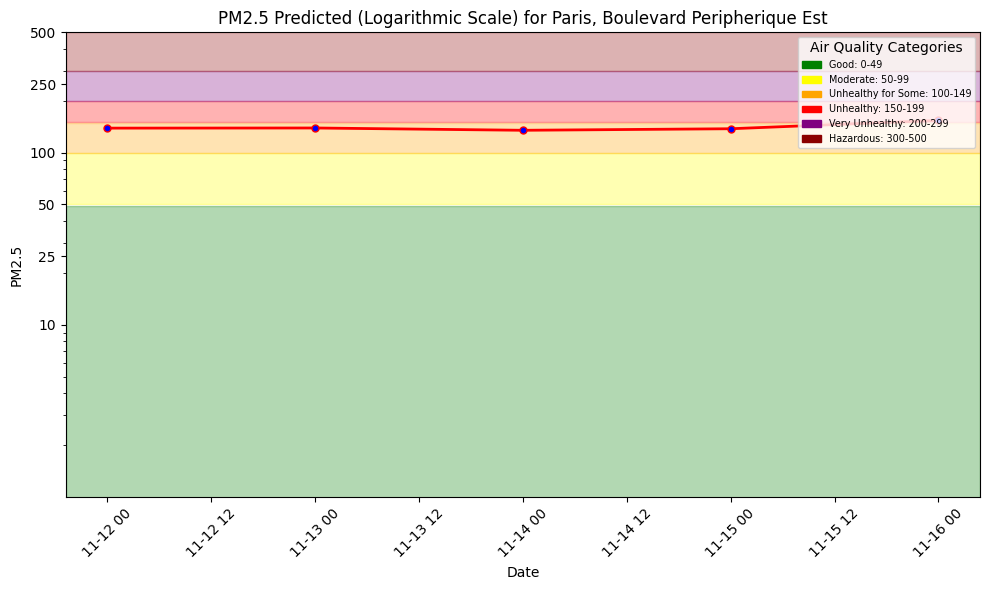

In [89]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [90]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [91]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00



Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1267871/jobs/named/aq_predictions_2_offline_fg_materialization/executions
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1267871/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-11 16:36:46,910 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-11 16:36:46,910 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-11 16:36:50,147 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-11 16:36:50,147 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-11 16:38:48,442 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-11 16:38:48,442 INFO: Waiting for executi

(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [92]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm_25_1_day_lag,pm_25_2_day_lag,pm_25_3_day_lag,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-12 00:00:00+00:00,15.15,0.0,11.620809,163.81073,Paris,NaN,NaN,NaN,138.781586,Boulevard Peripherique Est,France,1


In [93]:
# Use version 2 for actual outcomes (matches training data)
air_quality_fg_outcomes = fs.get_feature_group(name='air_quality', version=2)
air_quality_df = air_quality_fg_outcomes.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 


,date,pm25,pm_25_1_day_lag,pm_25_2_day_lag,pm_25_3_day_lag,country,city,street,url
0,2022-03-06 00:00:00+00:00,118.0,94.0,112.0,109.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
1,2023-12-28 00:00:00+00:00,41.0,45.0,41.0,32.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
2,2018-11-27 00:00:00+00:00,86.0,89.0,70.0,72.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
3,2015-10-24 00:00:00+00:00,69.0,68.0,61.0,77.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
4,2014-12-28 00:00:00+00:00,83.0,58.0,84.0,78.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
...,...,...,...,...,...,...,...,...,...
4169,2016-02-19 00:00:00+00:00,69.0,100.0,103.0,66.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
4170,2019-10-16 00:00:00+00:00,28.0,35.0,44.0,53.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
4171,2019-10-14 00:00:00+00:00,44.0,53.0,63.0,56.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/
4172,2021-06-30 00:00:00+00:00,38.0,32.0,38.0,47.0,France,Paris,Boulevard Peripherique Est,https://api.waqi.info/feed/@3088/


In [97]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 
⚠️ Warning: No matching dates found between weather and air quality data with complete lagged features
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 
⚠️ Warning: No matching dates found between weather and air quality data with complete lagged features


""


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

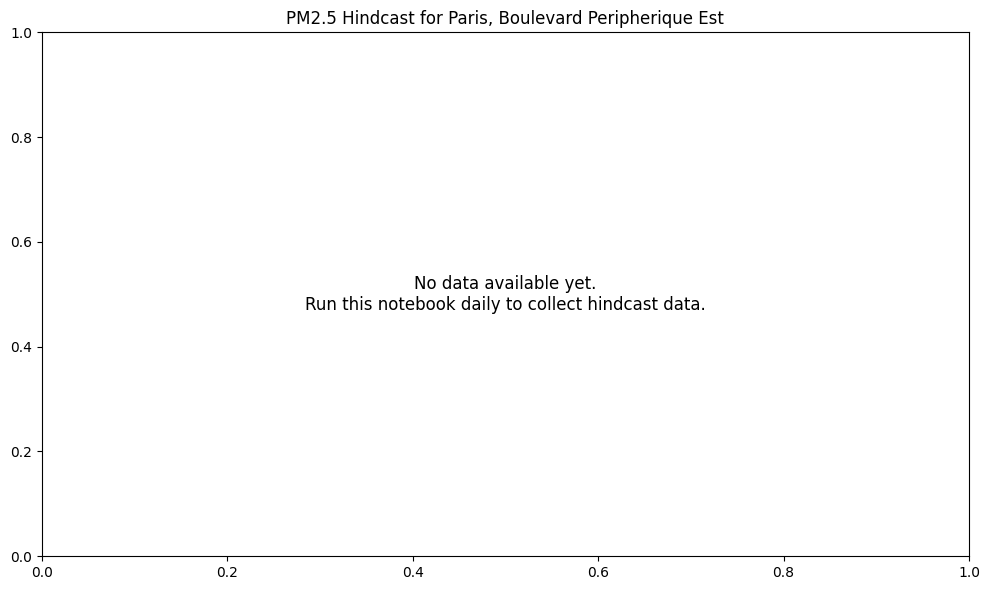

In [99]:
# Reload util to get the fix for empty dataframes
importlib.reload(util)

hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [100]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/sambarati/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|  …

Uploading /Users/sambarati/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.00…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1267871/settings/fb/path/Resources/airquality


---